In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import random
import os
import shutil
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree
from sklearn.metrics import silhouette_score
from collections import Counter

os.getcwd()
matplotlib.rc('font', family='SimHei', weight='light')
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Times New Roman', weight='light')
bar_width = 0.3
font1 = 20
font2 = 24
markerSize = 15
labelSize = 15
shadow = 0.3
bar_alpha = 0.8
italic_font = FontProperties(style='italic')
error_bar_properties = {
    'capsize': 5,  # Width of the caps at the ends of error bars
    'elinewidth': 1.5,  # Width of the error bar lines
    'ecolor': 'black',  # Color of the error bars
}

In [14]:
# Define the upper-left corner (reference point)
upper_left = (48.815, 2.255)  # Example: (latitude, longitude)
# Sample latitude and longitude points
data = pd.read_csv('./info_static_1.0.csv')
latitudes = data['latitude'].to_list()
longitudes = data['longitude'].to_list()
# Earth's approximate values
meters_per_deg_lat = 111320  # Meters per degree latitude
meters_per_deg_lon = meters_per_deg_lat * np.cos(np.radians(upper_left[0]))  # Adjust for longitude
# Convert lat/lon to relative positions based on the upper-left corner
relative_x = (np.array(longitudes) - upper_left[1]) * meters_per_deg_lon # Longitude difference
relative_y = (np.array(latitudes) - upper_left[0]) * meters_per_deg_lat  # Latitude difference (inverted for plotting)
data['x'] = relative_x
data['y'] = relative_y
data = data.sort_values(by=['t_id'])

data_unique = data.drop_duplicates(subset='s_id', keep='first')
data_unique['frequency'] = np.zeros(len(data_unique))
df_available = pd.read_csv('./ytrain_NpxebDC.csv')
for i in range(1, 100):
    s_columns = [col for col in df_available.columns if col.startswith(f'S{i}-')]
    count_num = (df_available[s_columns] == 'Charging').sum().sum()
    data_unique.loc[data_unique['s_id'] == f'S{i}', 'frequency'] = count_num
data_unique = data_unique.reset_index()
data_unique

/var/folders/rx/cn1t2knj48vd84v0ys5yhnzw0000gn/T/ipykernel_1878/712508050.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unique['frequency'] = np.zeros(len(data_unique))
/var/folders/rx/cn1t2knj48vd84v0ys5yhnzw0000gn/T/ipykernel_1878/712508050.py:19: DtypeWarning: Columns (1,3,5,11,20,49,52,54,55,56,64,70,71,94,95,101,102,114,129,131,132,133,138,139,152,157,163,174,180,184,193,196,201,207,208,219,220,228,241,245,250,256,258,264,265,269,270,271,272,273) have mixed types. Specify dtype option on import or set low_memory=False.
  df_available = pd.read_csv('./ytrain_NpxebDC.csv')


,index,t_id,s_id,latitude,longitude,Availability,street,city,zipcode,model,x,y,frequency
0,243,S1-T1,S1,48.855667,2.354089,1,4 PLACE SAINT GERVAIS,Paris,75004,"T3, E/F, CHAdeMO, Combo, T2",7263.558638,4527.05044,7619.0
1,142,S10-T1,S10,48.864240,2.397724,1,13 AVENUE DU PÈRE LACHAISE,Paris,75020,"Combo, T3, T2, CHAdeMO, E/F",10462.151633,5481.39680,9279.0
2,63,S11-T1,S11,48.861016,2.283080,1,24 AVENUE PAUL DOUMER,Paris,75016,"T2, CHAdeMO, T3, E/F, Combo",2058.358915,5122.50112,9697.0
3,190,S12-T1,S12,48.824388,2.336857,1,46 AVENUE REILLE,Paris,75014,"Combo, T2, CHAdeMO, T3, E/F",6000.394791,1045.07216,7205.0
4,159,S13-T1,S13,48.882640,2.335728,1,31 BOULEVARD DE CLICHY,Paris,75009,"T2, Combo, CHAdeMO, T3, E/F",5917.635275,7529.68480,4723.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,102,S95-T1,S95,48.868511,2.295469,1,37 Avenue iena,Paris,75016,"E/F, Combo, CHAdeMO, T2, T3",2966.514492,5956.84452,4.0
87,82,S96-T1,S96,48.835499,2.349650,1,21 Rue Berbier du Mets,Paris,75013,"CHAdeMO, T2, Combo, T3, E/F",6938.164934,2281.94868,9155.0
88,23,S97-T1,S97,48.839947,2.397822,1,5 Rue Docteur Goujon,Paris,75012,"CHAdeMO, Combo, T2, T3, E/F",10469.335364,2777.10004,6738.0
89,126,S98-T1,S98,48.849980,2.361920,1,4 quai Henry IV,Paris,75004,"Combo, T2, T3, E/F, CHAdeMO",7837.597409,3893.97360,0.0


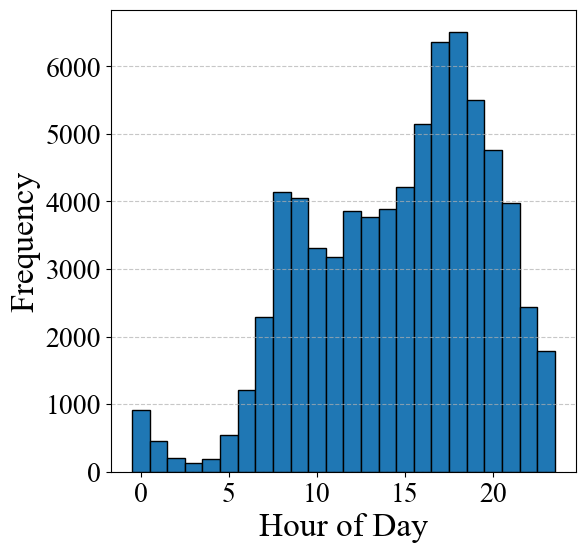

In [14]:
df = pd.read_csv('./ChargingRecords.csv')
df['hour'] = pd.to_datetime(df['StartTime'], format='%H:%M:%S').dt.hour
plt.figure(figsize=(6, 6))
plt.hist(df['hour'], bins=range(25), edgecolor='black', align='left')
plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('Hour of Day', fontsize=font2)
plt.ylabel('Frequency', fontsize=font2)
# plt.title('Frequency of Records by Hour')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./output_results/Frequency_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

def time_to_float(t):
    h, m, s = map(int, t.split(':'))
    return h + m/60 + s/3600

# df = df.sort_values(by=['StartDay'])
# probability = data_unique['frequency'] / data_unique['frequency'].sum()
# for value, group in df.groupby('StartDay'):
#     random_samples = np.random.choice(len(data_unique), size=len(group), p=probability)

#     x_coords, y_coords, grids = [], [], []
#     for index in random_samples:
#         x_coords.append(data_unique.loc[index, 'x'])
#         y_coords.append(data_unique.loc[index, 'y'])
#         grids.append(index)
#     group['x'] = x_coords
#     group['y'] = y_coords
#     group['grid_id'] = grids

#     group['demand'] = group['Duration'] / 60
#     group['time'] = group['StartTime'].apply(time_to_float)
#     group['energy'] = group['Demand']
#     group = group[['x', 'y', 'time', 'demand', 'energy', 'grid_id']].reset_index()

#     value = value.replace('/', '_')
#     filename = f'./ParisChargingDemands_real/{value}.csv'
#     group.to_csv(filename, index=True)

In [4]:
avail_prob = 0.25
avail_num = int(avail_prob * len(data))
chosen_station_indexes = np.random.choice(len(data), size=avail_num, replace=False)
availability = np.zeros(len(data))
availability[chosen_station_indexes] = 1
data['Availability'] = availability
data.to_csv(f'./info_static_{avail_prob}.csv', index=False)

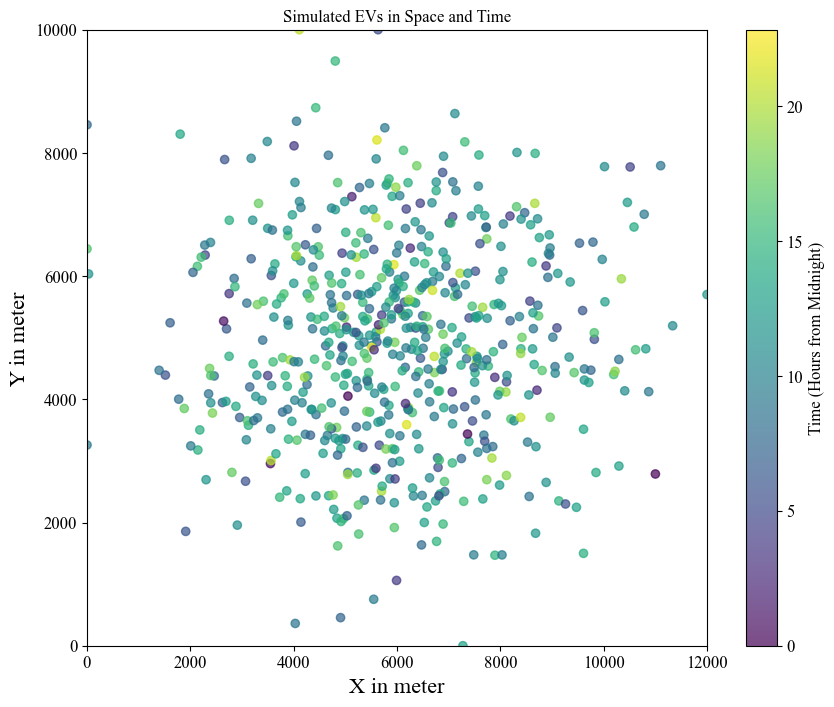

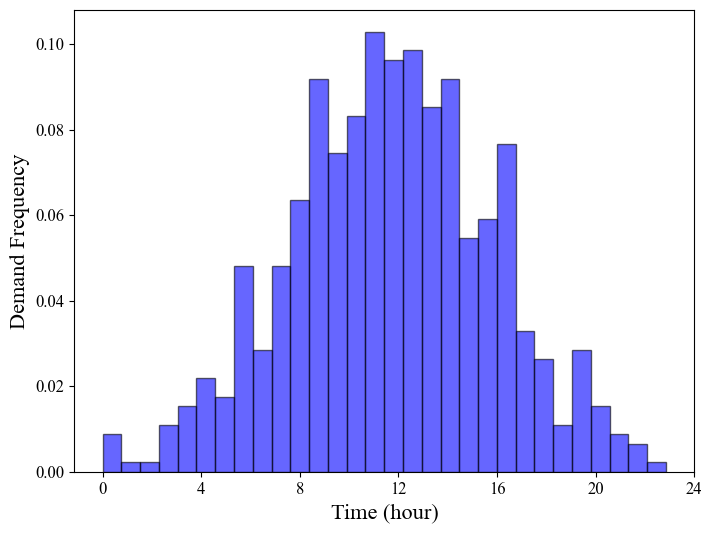

Range 0-59: 24076 occurrences
Range 60-119: 13879 occurrences
Range 120-179: 12237 occurrences
Range 180-239: 9084 occurrences
Range 240-299: 3746 occurrences
Range 300-359: 2846 occurrences
Range 360-419: 2264 occurrences
Range 420-479: 1539 occurrences
Range 480-539: 1018 occurrences
Range 540-599: 931 occurrences
Range 600-659: 741 occurrences
Range 660-719: 102 occurrences
Range 720-779: 80 occurrences
Range 780-839: 79 occurrences
Range 840-899: 57 occurrences
Range 900-959: 33 occurrences
Range 960-1019: 39 occurrences
Range 1020-1079: 31 occurrences
Range 1080-1139: 18 occurrences


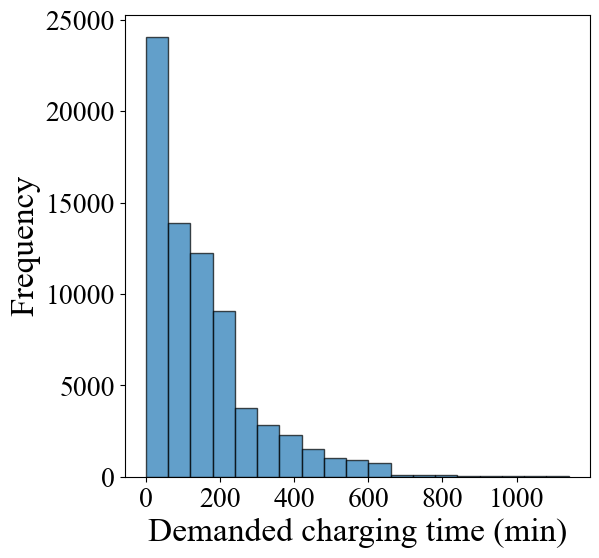

In [15]:
# Number of points to generate
num_points = 600
# Time type for distribution: weekday, weekend
type = 'weekend'

parent_path = f'./ParisChargingDemands_{type}/{num_points}EVs'
if not os.path.exists(parent_path):
    os.makedirs(parent_path)

for i in range(40):

    # Step 1: Define Gaussian distribution parameters
    x_mean, x_std = 6000, 2000  # Centered at 6000, std of 2000
    y_mean, y_std = 5000, 1600   # Centered at 5000, std of 1500
    # Set the mean and standard deviation for temporal distribution
    time_mean, time_std = 12, 4  # Centered at 12 hours, std of 4 hours

    # Step 2: Generate Gaussian distributed points
    x_coords = np.clip(np.random.normal(x_mean, x_std, num_points), 0, 12000)  # meter
    y_coords = np.clip(np.random.normal(y_mean, y_std, num_points), 0, 10000)  # meter

    if type == 'weekday':
        morning_peak = np.random.normal(loc=8, scale=1.6, size=int(num_points * 0.4))  # Peak around 8 AM
        afternoon_peak = np.random.normal(loc=17, scale=1.2, size=int(num_points * 0.4))  # Peak around 5 PM
        midday = np.random.normal(loc=13, scale=2.0, size=int(num_points * 0.2))
        time_stamps = np.clip(np.concatenate([morning_peak, afternoon_peak, midday]), 0, 24)
    elif type == 'weekend':
        time_stamps = np.clip(np.random.normal(time_mean, time_std, num_points), 0, 24)  # hour
    else:
        print("Wrong time type!!!")
        break

    # Set charging time for demands (hour)
    low, high = 1, 5
    x = np.linspace(low, high, num_points)
    y = np.exp(-x)
    charging_demands = low + (high - low) * (y - np.min(y)) / (np.max(y) - np.min(y))
    # charging_demands = np.random.choice([1, 1.5, 2, 2.5, 3], num_points)

    demands_df = pd.DataFrame({
        'x': x_coords,
        'y': y_coords,
        'time': time_stamps,
        'demand': charging_demands
    })
    path = parent_path + f'/demands_dist{i}.csv'
    demands_df.to_csv(path)


# Step 3: Plot the points on a 2D map
plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, c=time_stamps, cmap="viridis", alpha=0.7)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Time (Hours from Midnight)", fontsize=12)
plt.xlim([0, 12000])
plt.ylim([0, 10000])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("X in meter", fontsize=16)
plt.ylabel("Y in meter", fontsize=16)
plt.title("Simulated EVs in Space and Time")
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(time_stamps, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
plt.xticks(np.linspace(0, 24, num=7), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Time (hour)', fontsize=16)
plt.ylabel('Demand Frequency', fontsize=16)
plt.show()

# Simulate the charging demands of EVs
read_data = pd.read_csv('./ChargingRecords.csv')
data = read_data['Duration'].to_numpy()

# Compute the frequency for each 10-range bin
bins = np.arange(0, 1200, 60)
hist, bin_edges = np.histogram(data, bins=bins)

for i in range(len(hist)):
    print(f"Range {bin_edges[i]}-{bin_edges[i+1]-1}: {hist[i]} occurrences")

# Compute bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
# Plot histogram using bar chart
plt.figure(figsize=(6, 6))
plt.bar(bin_centers, hist, width=np.diff(bin_edges), edgecolor='black', alpha=0.7)
plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('Demanded charging time (min)', fontsize=font2)
plt.ylabel('Frequency', fontsize=font2)
plt.savefig('./output_results/Frequency_duration.pdf', dpi=300, bbox_inches='tight')
# plt.title('Frequency of charging demands in ENS Challenge Data')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


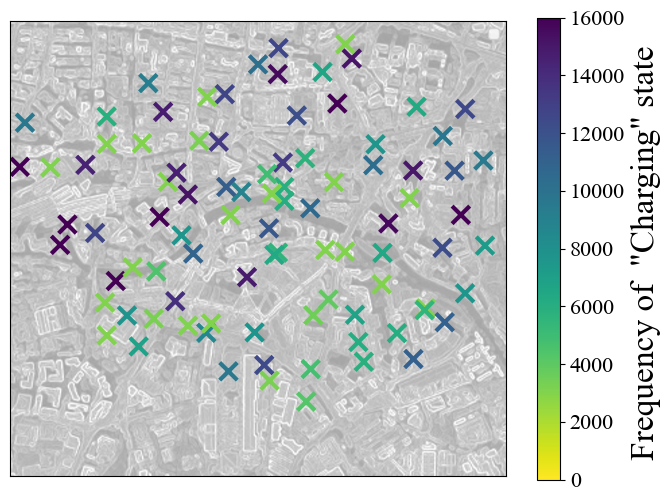

0.03818382536512296

In [16]:
from PIL import Image
bg_image = Image.open("output_results/map3.png")
bg_image = bg_image.resize((12000, 11000))
bg_array = np.array(bg_image)
height, width = bg_array.shape[0], bg_array.shape[1]

frequency = data_unique['frequency'] + 3000

num_grids = 36
# Generate grid lines
xmax, ymax = 12000, 10000
n = int(np.sqrt(num_grids))
xedge, yedge = xmax / n, ymax / n
x_vals = np.linspace(0, xmax, n+1)
y_vals = np.linspace(0, ymax, n+1)
plt.figure(figsize=(8, 6))
plt.imshow(bg_image)
sc = plt.scatter(data_unique['x'], data_unique['y'], c=frequency, 
                 cmap='viridis_r', marker='x', s=160, linewidths=3, vmin=0, vmax=16000)
cbar = plt.colorbar(sc)
cbar.ax.tick_params(labelsize=16)
cbar.set_label("Frequency of  \"Charging\" state ", fontsize=font2)

# # Draw vertical grid lines
# for x in x_vals:
#     plt.vlines(x, 0, ymax, colors='k', linestyles='dashed', alpha=0.6)
# # Draw horizontal grid lines
# for y in y_vals:
#     plt.hlines(y, 0, xmax, colors='k', linestyles='dashed', alpha=0.6)
# for grid_id in range(num_grids):
#     grid_x = grid_id % n * xedge
#     grid_y = grid_id // n * yedge
#     plt.text(grid_x, grid_y, int(grid_id + 1), fontsize=20)
plt.xticks([])
plt.yticks([])
plt.legend()
# plt.savefig('./output_results/Stations_dist.pdf', dpi=300)
plt.show()

a = data_unique['frequency'] / sum(data_unique['frequency'])
max(a)

# # Generate clustering grids
# data_target = data_unique[['x', 'y']]
# kmeans = KMeans(n_clusters=num_grids, random_state=0)
# kmeans.fit(data_target)
# # Get the cluster centroids (these are the seeds for the Voronoi diagram)
# voronoi_sites = kmeans.cluster_centers_
# voronoi_sites = voronoi_sites[np.lexsort((voronoi_sites[:, 1], voronoi_sites[:, 0]))]
# voron = Voronoi(voronoi_sites)
# plt.figure(figsize=(10, 8))
# sc = plt.scatter(data_unique['x'], data_unique['y'], c=data_unique['frequency'], cmap='viridis', s=80)
# cbar = plt.colorbar(sc)
# voronoi_plot_2d(voron, ax=plt.gca(), show_points=False, show_vertices=False, line_colors='orange', line_width=2)
# for i, (xi, yi) in enumerate(zip(voronoi_sites[:, 0], voronoi_sites[:, 1])):
#     plt.text(xi, yi, str(i), fontsize=30, ha='right', color='red')
# plt.xlim(0, 12000)
# plt.ylim(0, 10000)
# plt.xlabel('X in meter', fontsize=21)
# plt.ylabel('Y in meter', fontsize=21)
# # plt.title(f'Voronoi Diagram: Divided by {num_grids} grids', fontsize=21)
# plt.legend()
# plt.show()

# # Find neighboring grids for each point
# neighbors = {i: set() for i in range(len(voronoi_sites))}
# for ridge in voron.ridge_points:
#     p1, p2 = ridge
#     neighbors[p1].add(p2)
#     neighbors[p2].add(p1)
# # Print neighboring grids
# for i, nbrs in neighbors.items():
#     print(f"Grid {i} neighbors: {list(nbrs)}")


# num_points = 600
# x_mean, x_std = 6000, 2000 
# y_mean, y_std = 5000, 1600
# time_mean, time_std = 12, 4
# x_coords = np.clip(np.random.normal(x_mean, x_std, num_points), 0, 12000)  # meter
# y_coords = np.clip(np.random.normal(y_mean, y_std, num_points), 0, 10000)  # meter
# plt.figure(figsize=(8, 6))
# plt.scatter(x_coords, y_coords, color='blue')
# for x in x_vals:
#     plt.vlines(x, 0, ymax, colors='k', linestyles='dashed', alpha=0.6)
# for y in y_vals:
#     plt.hlines(y, 0, xmax, colors='k', linestyles='dashed', alpha=0.6)
# plt.xticks([])
# plt.yticks([])
# plt.legend()
# plt.savefig('./output_results/Requests_dist.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# time_stamps = np.clip(np.random.normal(time_mean, time_std, num_points), 0, 24)  # hour
# plt.figure(figsize=(6, 5))
# plt.hist(time_stamps, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
# plt.xticks(np.linspace(0, 24, num=7), fontsize=font1)
# plt.yticks(fontsize=font1)
# plt.xlabel('Time window (hour)', fontsize=font2)
# plt.ylabel('Probability density', fontsize=font2)
# plt.savefig('./output_results/Weekend_dist.pdf', dpi=300, bbox_inches='tight')
# plt.show()

# morning_peak = np.random.normal(loc=8, scale=1.6, size=int(num_points * 0.4))  # Peak around 8 AM
# afternoon_peak = np.random.normal(loc=17, scale=1.2, size=int(num_points * 0.4))  # Peak around 5 PM
# midday = np.random.normal(loc=13, scale=2.0, size=int(num_points * 0.2))
# time_stamps = np.clip(np.concatenate([morning_peak, afternoon_peak, midday]), 0, 24)
# plt.figure(figsize=(6, 5))
# plt.hist(time_stamps, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
# plt.xticks(np.linspace(0, 24, num=7), fontsize=font1)
# plt.yticks(fontsize=font1)
# plt.xlabel('Time window (hour)', fontsize=font2)
# plt.ylabel('Probability density', fontsize=font2)
# plt.savefig('./output_results/Weekday_dist.pdf', dpi=300, bbox_inches='tight')
# plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


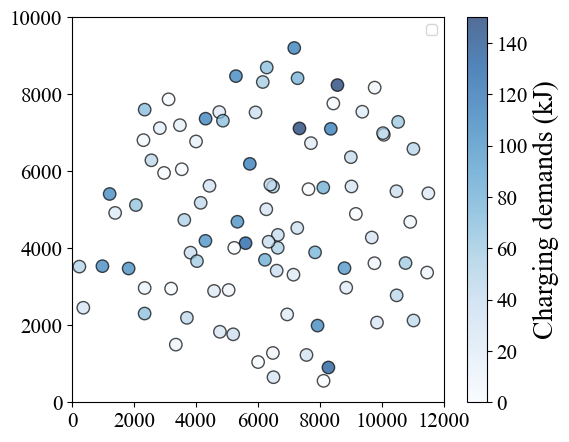

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


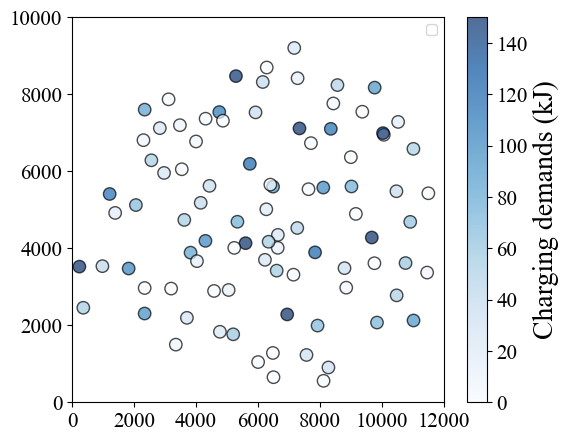

88
74


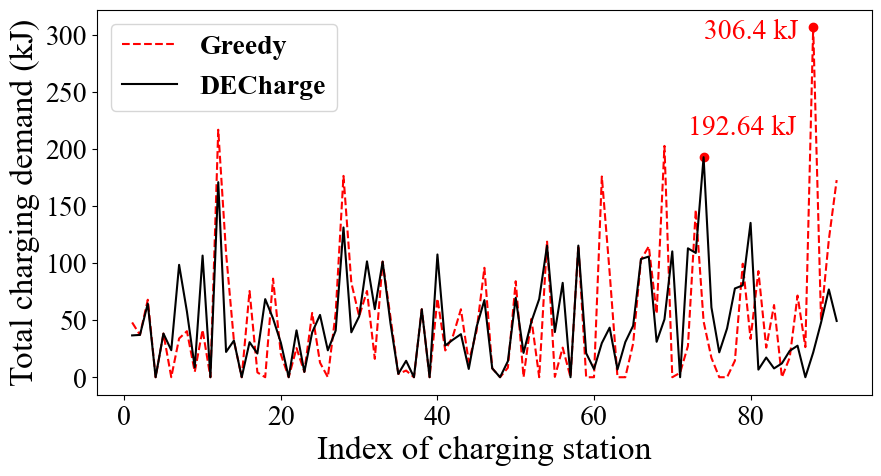

In [3]:
data_new = data_unique.sort_values(by='s_id')
data_new = data_new.drop_duplicates(subset='s_id', keep='first')
demands_data = pd.read_csv('./output_results/Charging_demands.csv')
demands_data = demands_data * 3.6 * 1.8

epos = demands_data['EPOS']
greedy = demands_data['greedy']
cohda = demands_data['COHDA']
static = demands_data['static_initial']

plt.figure(figsize=(6, 5))
plt.scatter(data_new['x'], data_new['y'], 
            s=80, c=epos, cmap='Blues', alpha=0.7, edgecolors='black', 
            vmin=0, vmax=150)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label("Charging demands (kJ)", fontsize=20)
plt.xlim([0, 12000])
plt.ylim([0, 10000])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(data_new['x'], data_new['y'], 
            s=80, c=greedy, cmap='Blues', alpha=0.7, edgecolors='black', 
            vmin=0, vmax=150)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)

cbar.set_label("Charging demands (kJ)", fontsize=20)
plt.xlim([0, 12000])
plt.ylim([0, 10000])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()
plt.show()

x = range(1, len(epos) + 1)
plt.figure(figsize=(10, 5))
# plt.plot(x, cohda, linestyle='--', color='b', label='COHDA')
greedy = greedy.to_list()
epos = epos.to_list()
plt.plot(x, greedy, linestyle='--', color='r', label='Greedy')
plt.plot(x, epos, linestyle='-', color='k', label='DECharge')
min_index = greedy.index(min(greedy))+1
max_index = greedy.index(max(greedy))+1
min_index2 = epos.index(min(epos))+1
max_index2 = epos.index(max(epos))+1
print(max_index)
print(max_index2)
# plt.scatter(min_index, min(greedy), color='red')
# plt.text(min_index + 4, min(greedy) - 1, f'{round(min(greedy), 2)} kJ', 
#          ha='left', color='red', fontsize=labelSize)
plt.scatter(max_index, max(greedy), color='red')
plt.text(max_index - 14, max(greedy) - 10, f'{round(max(greedy), 2)} kJ', 
         ha='left', color='red', fontsize=font1)
# plt.scatter(min_index2, min(epos), color='red')
# plt.text(min_index2 + 4, min(epos) - 1, f'{round(min(epos), 2)} kJ', 
#          ha='left', color='red', fontsize=labelSize)
plt.scatter(max_index2, max(epos), color='red')
plt.text(max_index2 - 2, max(epos) + 20, f'{round(max(epos), 2)} kJ', 
         ha='left', color='red', fontsize=font1)
plt.xticks(fontsize=font1)
plt.yticks(fontsize=font1)
plt.xlabel('Index of charging station', fontsize=font2)
plt.ylabel('Total charging demand (kJ)', fontsize=font2)
plt.legend(loc='upper left', prop={'weight': 'bold', 'size': font1})
plt.savefig('./output_results/Charging_demand_compare.pdf', dpi=300, bbox_inches='tight')
plt.show()